# Random Forests

In [1]:
%load_ext autoreload
%autoreload 2

# Random Forests

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from eval import MAE, custom_metric


from preprocess import data

np.random.seed(0)


In [3]:
x_tl = data["x_timed_lagged"].reset_index(drop=True).shift(1)
x_germany = data["x_germany"].reset_index(drop=True)
x_austria = data["x_austria"].reset_index(drop=True)
y_germany = data["y_germany"][1:].reset_index(drop=True)
y_austria = data["y_austria"][1:].reset_index(drop=True)

x_germany = pd.concat([x_germany, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])
x_austria = pd.concat([x_austria, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])

In [4]:
x_germany

,tavg,tmin,tmax,wdir,wspd,wpgt,pres,GERMANY_BLOCK_DEMAND_[MW],TOTAL_DEMAND_[MW],GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]
0,5.0,3.5,6.7,164,14.8,31.5,999.9,1815,2015,5.25
1,8.7,6.9,10.6,218,19.9,44.5,989.8,1813,2013,5.19
2,5.2,1.2,8.5,277,19.3,55.5,997.2,1884,2084,4.88
3,0.6,-0.1,1.5,97,14.6,33.3,1006.2,1757,1957,4.64
4,0.3,-1.0,1.5,79,16.8,37.0,1010.9,1815,2015,4.90
...,...,...,...,...,...,...,...,...,...,...
238,19.2,11.9,26.5,119,9.9,25.9,1023.0,1852,2077,7.97
239,21.8,15.0,29.0,109,13.4,31.5,1020.4,1923,2148,6.47
240,24.2,18.9,30.4,136,12.3,29.6,1016.6,1827,2052,6.03
241,21.6,18.3,26.0,163,11.5,27.8,1016.4,1885,2110,5.44


In [5]:
x_tl

,TOTAL_MIN_CAPACITY_PRICE_[(EUR/MW)/h],TOTAL_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MIN_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_IMPORT(-)_EXPORT(+)_[MW],AUSTRIA_MIN_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_IMPORT(-)_EXPORT(+)_[MW],GERMANY_SUM_OF_OFFERED_CAPACITY_[MW]
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.20,4.63,5.25,4.01,4.72,5.25,21.0,2.20,3.78,5.01,-21.0,3637.0
2,2.40,4.64,5.19,4.20,4.71,5.19,-68.0,2.40,4.23,5.13,68.0,3671.0
3,2.34,4.50,4.88,3.51,4.54,4.88,42.0,2.34,4.01,4.80,-42.0,3860.0
4,2.28,4.24,4.64,3.20,4.29,4.64,33.0,2.28,3.74,4.60,-33.0,3913.0
...,...,...,...,...,...,...,...,...,...,...,...,...
239,2.67,6.52,7.97,4.88,6.86,7.97,-80.0,2.67,4.61,6.13,80.0,4985.0
240,3.60,5.94,7.25,5.00,5.95,6.47,80.0,3.60,5.77,7.25,-80.0,5088.0
241,2.67,5.50,6.03,4.65,5.59,6.03,-23.0,2.67,4.81,6.02,23.0,4893.0
242,2.57,5.16,5.44,4.55,5.22,5.44,43.0,2.57,4.52,5.43,-43.0,4789.0


In [7]:
X_ger = pd.concat([x_germany, x_tl], axis=1).dropna().reset_index(drop=True) #drop the first row of the df due to .shift(1)
X_aust = pd.concat([x_austria, x_tl], axis=1).dropna().reset_index(drop=True)

y_ger = y_germany.iloc[1:].reset_index(drop=True)
y_aus = y_austria.iloc[1:].reset_index(drop=True)

In [8]:
X_ger

,tavg,tmin,tmax,wdir,wspd,wpgt,pres,GERMANY_BLOCK_DEMAND_[MW],TOTAL_DEMAND_[MW],GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],...,TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MIN_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_IMPORT(-)_EXPORT(+)_[MW],AUSTRIA_MIN_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_IMPORT(-)_EXPORT(+)_[MW],GERMANY_SUM_OF_OFFERED_CAPACITY_[MW]
0,8.7,6.9,10.6,218.0,19.9,44.5,989.8,1813.0,2013.0,5.19,...,5.25,4.01,4.72,5.25,21.0,2.20,3.78,5.01,-21.0,3637.0
1,5.2,1.2,8.5,277.0,19.3,55.5,997.2,1884.0,2084.0,4.88,...,5.19,4.20,4.71,5.19,-68.0,2.40,4.23,5.13,68.0,3671.0
2,0.6,-0.1,1.5,97.0,14.6,33.3,1006.2,1757.0,1957.0,4.64,...,4.88,3.51,4.54,4.88,42.0,2.34,4.01,4.80,-42.0,3860.0
3,0.3,-1.0,1.5,79.0,16.8,37.0,1010.9,1815.0,2015.0,4.90,...,4.64,3.20,4.29,4.64,33.0,2.28,3.74,4.60,-33.0,3913.0
4,-2.3,-3.6,-1.3,36.0,16.3,35.2,1022.9,1823.0,2023.0,4.22,...,4.90,3.25,4.15,4.90,-41.0,2.03,3.90,4.86,41.0,3696.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,19.2,11.9,26.5,119.0,9.9,25.9,1023.0,1852.0,2077.0,7.97,...,16.78,4.55,6.40,16.78,-80.0,2.77,4.48,6.62,80.0,4563.0
238,21.8,15.0,29.0,109.0,13.4,31.5,1020.4,1923.0,2148.0,6.47,...,7.97,4.88,6.86,7.97,-80.0,2.67,4.61,6.13,80.0,4985.0
239,24.2,18.9,30.4,136.0,12.3,29.6,1016.6,1827.0,2052.0,6.03,...,7.25,5.00,5.95,6.47,80.0,3.60,5.77,7.25,-80.0,5088.0
240,21.6,18.3,26.0,163.0,11.5,27.8,1016.4,1885.0,2110.0,5.44,...,6.03,4.65,5.59,6.03,-23.0,2.67,4.81,6.02,23.0,4893.0


## Classical Random Forest

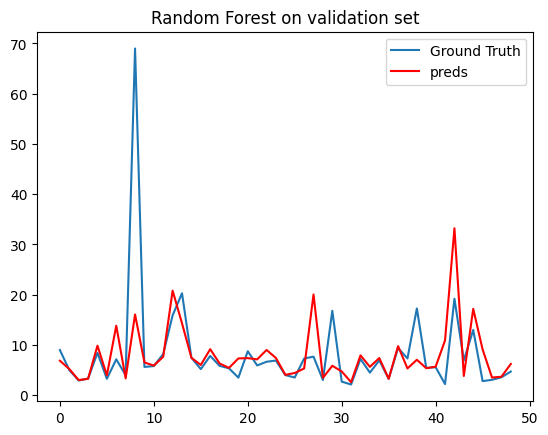

Mean Squared Error: 75.06129381632655


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_ger, y_ger, test_size=0.2)

model = RandomForestRegressor(n_estimators=10, random_state=42)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_valid)

# Evaluate the model
plt.plot(y_valid.reset_index(drop=True), label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title("Random Forest on validation set")
plt.legend()
plt.show()

mse = mean_squared_error(y_valid.reset_index(drop=True), y_pred)
print(f'Mean Squared Error: {mse}')

## Without split

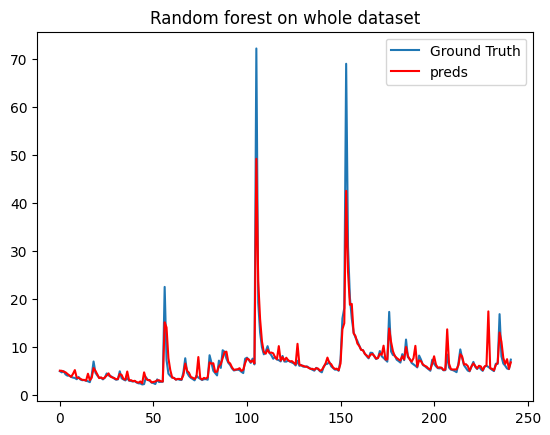

Mean Squared Error: 7.261044500413222


In [10]:


model = RandomForestRegressor(n_estimators=100, random_state=42, )

model.fit(X_ger, y_ger)

# Make predictions on the test set
y_pred = model.predict(X_ger)

# Evaluate the model
plt.plot(y_ger, label='Ground Truth')
plt.plot(y_pred, color='red', label='preds')
plt.title('Random forest on whole dataset')
plt.legend()
plt.show()

mse = mean_squared_error(y_ger.reset_index(drop=True), y_pred)
print(f'Mean Squared Error: {mse}')

## Dynamic Random Forest

In [11]:
X_ger[:6]

,tavg,tmin,tmax,wdir,wspd,wpgt,pres,GERMANY_BLOCK_DEMAND_[MW],TOTAL_DEMAND_[MW],GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],...,TOTAL_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MIN_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],GERMANY_IMPORT(-)_EXPORT(+)_[MW],AUSTRIA_MIN_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_AVERAGE_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h],AUSTRIA_IMPORT(-)_EXPORT(+)_[MW],GERMANY_SUM_OF_OFFERED_CAPACITY_[MW]
0,8.7,6.9,10.6,218.0,19.9,44.5,989.8,1813.0,2013.0,5.19,...,5.25,4.01,4.72,5.25,21.0,2.20,3.78,5.01,-21.0,3637.0
1,5.2,1.2,8.5,277.0,19.3,55.5,997.2,1884.0,2084.0,4.88,...,5.19,4.20,4.71,5.19,-68.0,2.40,4.23,5.13,68.0,3671.0
2,0.6,-0.1,1.5,97.0,14.6,33.3,1006.2,1757.0,1957.0,4.64,...,4.88,3.51,4.54,4.88,42.0,2.34,4.01,4.80,-42.0,3860.0
3,0.3,-1.0,1.5,79.0,16.8,37.0,1010.9,1815.0,2015.0,4.90,...,4.64,3.20,4.29,4.64,33.0,2.28,3.74,4.60,-33.0,3913.0
4,-2.3,-3.6,-1.3,36.0,16.3,35.2,1022.9,1823.0,2023.0,4.22,...,4.90,3.25,4.15,4.90,-41.0,2.03,3.90,4.86,41.0,3696.0
5,-5.4,-6.9,-3.5,53.0,15.6,31.5,1033.4,1824.0,2024.0,3.95,...,4.22,2.76,4.01,4.22,40.0,1.95,3.60,4.21,-40.0,4082.0


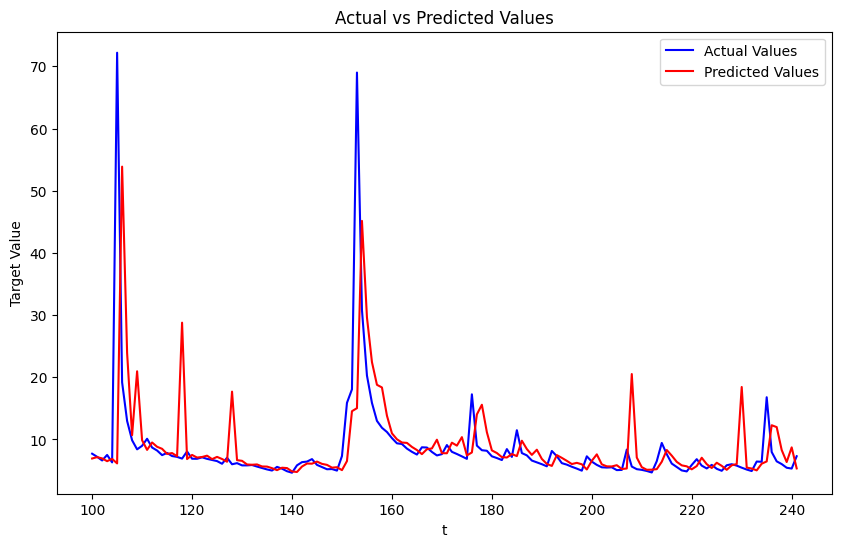

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X = X_ger
y = y_ger

model = RandomForestRegressor(n_estimators=50, random_state=42)

actual_values = []
predicted_values = []

for t in range(100, len(X)):
    X_train = X[:t]
    y_train = y[:t]
    X_test = X.iloc[[t-1]]  

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    actual_values.append(y[t])
    predicted_values.append(y_pred[0])

plt.figure(figsize=(10, 6))
plt.plot(range(100, len(X)), actual_values, label='Actual Values', color='blue')
plt.plot(range(100, len(X)), predicted_values, label='Predicted Values', color='red')
plt.xlabel('t')
plt.ylabel('Target Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Grid search for best parmaterers

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

X, y = x_austria, y_austria

param_grid = {
    'n_estimators': [50, 60, 70, 80, 90,100, 200],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11, 12, 13, 14, 15, 20, 30]
}

tscv = TimeSeriesSplit(n_splits=5)

best_score = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        bootstrap_indices = np.random.choice(train_index, size=len(train_index), replace=True)
        X_bootstrap = X.iloc[bootstrap_indices]
        y_bootstrap = y.iloc[bootstrap_indices]

        rf = RandomForestRegressor(random_state=0, **params)
        rf.fit(X_bootstrap, y_bootstrap)

        y_pred = rf.predict(X_test)
        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)

    avg_score = np.mean(scores)

    if avg_score < best_score:
        best_score = avg_score
        best_params = params

print("Meilleurs paramètres :", best_params)
print("Meilleur score (MAE) :", best_score)


Meilleurs paramètres : {'max_depth': 2, 'n_estimators': 70}
Meilleur score (MAE) : 1.0889328050673808


## Random forest with best parameters

In [21]:
X, y = x_austria, y_austria


y_pred = []
for k in range(100, len(X)):
    # Sélectionnez les indices avec remise pour le bootstrap
    bootstrap_indices = np.random.choice(range(k), size=k, replace=True)

    X_train = X.iloc[bootstrap_indices]
    y_train = y.iloc[bootstrap_indices]

    X_valid = X.iloc[[k]]
    y_valid = y.iloc[k]

    regressor = RandomForestRegressor(random_state=0, max_depth=3, n_estimators=70)
    regressor.fit(X_train, y_train)

    leaf_indices = regressor.apply(X_train)
    unique_leaves = np.unique(leaf_indices)

    ridge_models = {}

    y_pred.append(regressor.predict(X_valid)[0])

(1.1586276782518476, 1.8607418688905368)
(1038.4067570915233, 837.5280802120836)


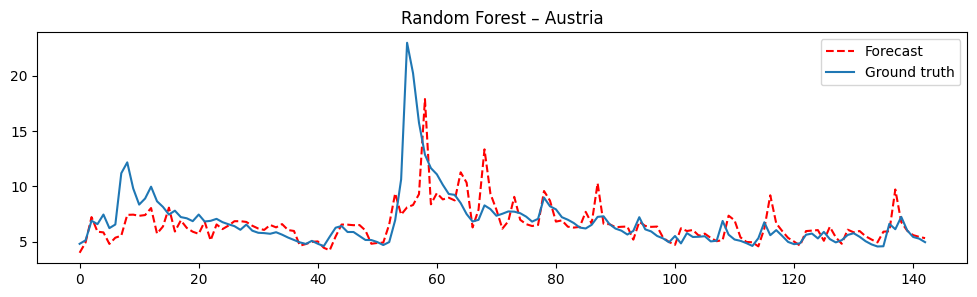

In [24]:
from eval import custom_metric

fig, ax = plt.subplots(figsize=(12, 3))

# Calculate and print metrics
print(MAE(y_pred, y[100:]))
print(custom_metric(y_pred, y[100:], country="Austria"))

# Plot the data
ax.plot(y_pred, label="Forecast", linestyle="--", color="red")
ax.plot(y.values[100:], label="Ground truth")
ax.set_title("Random Forest – Austria")
# Add legend
ax.legend()
plt.savefig("graphs/Random Forest.png", dpi=300)

# Show plot
plt.show()